In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os, sys, shutil
sys.path.append("..")
import pandas as pd

from lammpsrun import *
from PBSJobSubmissionScript import PBS_Submitter, qstat_monitor
from utility_scripts import *

from ase import Atoms, units
from ase.visualize.plot import plot_atoms
from ase.io.trajectory import Trajectory
from ase.io import write, read
from ase.build import molecule, bcc110, bcc111
from ase.spacegroup import crystal
from ase.data import atomic_numbers, atomic_names, atomic_masses, covalent_radii

cx1_out = r"/rds/general/user/yx6015/home/cx1_out/"
ephemeral = r"/rds/general/user/yx6015/ephemeral/"
sim_path = r"/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/"
convert_scripts_dir = r"/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Scripts/"
print(cx1_out + '\n' + sim_path)
potential = "fe_o_water_fe_o_c_full_water.reax"
Fe_aq_co2_dir = os.path.join(sim_path, "ferrite_aq_co2")

/rds/general/user/yx6015/home/cx1_out/
/rds/general/user/yx6015/home/LAMMPS_Simulation/HPC_Jupyter/


## Creating the Simulation Box

### Create the Iron Bits

In [3]:
aq_thickness = 100
n_co2 = 100

In [4]:
Fe_bcc111_l32 = bcc111('Fe', a=2.870, size=(10,10,32), orthogonal=True, vacuum=0)
Fe_bcc111_l32.set_cell(Fe_bcc111_l32.get_cell() + np.array([[0,0,0],[0,0,0],[0,0,aq_thickness]]))

### Creating Water Content

In [5]:
aq_cell_l100 = np.array(list(Fe_bcc111_l32.get_cell_lengths_and_angles()[:2]) + [aq_thickness])
H2O_l100 = create_water_region(aq_cell_l100*0.995)

### Substituting with CO2

In [6]:
# To ensure repeatability
np.random.seed(1050027)
ns_remove = np.random.choice(int(H2O_l100.get_number_of_atoms()/3), size=n_co2, replace=False)*3

H2O_l100_co2 = H2O_l100.copy()
for n in ns_remove:
    H2O_l100_co2 = replace_molecule(H2O_l100_co2, n, molecule('CO2'), cut_off=0.8)
    
H2O_l100_co2

Atoms(symbols='C98H8950O4671', pbc=True, cell=[40.384989593907285, 34.974426919893915, 99.5])

### Merging to Create Final Simulation Box

In [14]:
H2O_l100_co2.translate([0, 0, Fe_bcc111_l32.get_cell_lengths_and_angles()[2]-aq_thickness])
Fe_aq_co2 = Fe_bcc111_l32 + H2O_l100_co2
Fe_aq_co2.set_pbc([True, True, False])
Fe_aq_co2

Atoms(symbols='C98H8950Fe3200O4671', pbc=[True, True, False], cell=[40.587929240107826, 35.15017780893861, 125.6834267249005], tags=...)

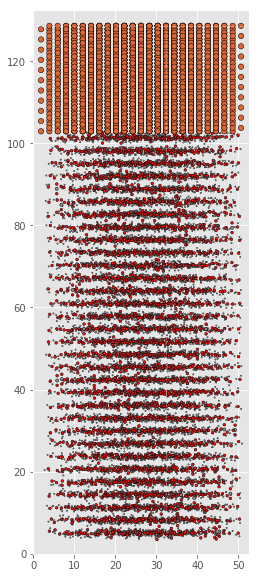

In [15]:
plt.figure(figsize=(18, 10))
plot_atoms(Fe_aq_co2, radii=0.5, rotation=('90x,60y,0z'), show_unit_cell=True)
#Fe_bcc111_l40_aq.write(sim_path + "fe_aq/Fe_bcc111_l40_aq.extxyz")
plt.show()

In [19]:
Fe_aq_co2_efields = np.arange(0.4, 0.7, 0.3) # V/A = 100MV/cm => 0 MV/cm to 45 MV/cm
Fe_aq_co2_efields_names = ['Fe_aq_co2_efields_{0:.0f}MVcm'.format(x*100) for x in Fe_aq_co2_efields]
Fe_aq_co2_efields_names

['Fe_aq_co2_efields_40MVcm']

In [20]:
for sim, efield in zip(Fe_aq_co2_efields_names, Fe_aq_co2_efields):
    calc = reaxff_params_generator(Fe_aq_co2, sim,
                                   write_input=True,
                                   input_fd=Fe_aq_co2_dir,
                                   run=500,
                                   timestep=0.1,
                                   region="mobile block EDGE EDGE EDGE EDGE 5.0 EDGE side in units box", # neglect bottom 2 layers
                                   group="mobile_g region mobile",
                                   fix=["all_nvt mobile_g nvt temp 300.0 300.0 100.0",
                                        "qeq_reaxc all qeq/reax 1 0.0 10.0 1e-6 reax/c",
                                        "elec mobile_g efield 0.0 0.0 {0:.2f}".format(efield),
                                        "reax_info all reax/c/bonds 10 bonds.tatb",
                                        "zwalls all wall/reflect zlo EDGE zhi EDGE",],
                                   velocity=["all create 300.0 1050027 rot yes mom yes dist gaussian"],
                                   potential=potential)

In [43]:
Fe_aq_co2_efields_commands = [["mpiexec lmp_intel_cpu_intelmpi -sf omp -pk omp 8 -in {0}.lammpsin -screen none\n".format(x),
                               "python convert_script_nocopy_fast.py {} {} 32".format(x, x+'.lammpstrj')] for x in Fe_aq_co2_efields_names]
Fe_aq_co2_efields_source_files = [['$HOME/LAMMPS_Simulation/potentials/{0}'.format(potential),
                                   '$PBS_O_WORKDIR/{}.*'.format(x),
                                   os.path.join(convert_scripts_dir, "convert_script_nocopy_fast.py"),
                                   os.path.join(convert_scripts_dir, "minimal_traj_conversion.py")] for x in Fe_aq_co2_efields_names]

Fe_aq_co2_efields_PBS = PBS_Submitter(job_names=Fe_aq_co2_efields_names,
                                      job_commands=Fe_aq_co2_efields_commands,
                                      modules=["mpi", "lammps/11Aug17", "intel-suite/2017, anaconda3/personal"],
                                      walltime="24:00:00",
                                      proc_nodes=1,
                                      proc_cpus=32, #mpiprocs x threads = cpus
                                      proc_mpiprocs=4, 
                                      proc_threads=8,
                                      memory=60,
                                      source_files=Fe_aq_co2_efields_source_files)

In [44]:
os.chdir(Fe_aq_co2_dir)

Fe_aq_co2_efields_out, Fe_aq_co2_efields_err = Fe_aq_co2_efields_PBS.run()

os.chdir(sim_path)
print(Fe_aq_co2_efields_out, Fe_aq_co2_efields_names)

['9064.pbs'] ['Fe_aq_co2_efields_40MVcm']


In [8]:
# Move all the log and error files over

for outfile, job_out in zip(Fe_bcc111_l32_aq_l100_efields_names, Fe_bcc111_l32_aq_l100_efields_out):
    shutil.move(os.path.join(Fe_aq_co2_dir, outfile + ".err"), os.path.join(ephemeral, job_out))
    shutil.move(os.path.join(Fe_aq_co2_dir, outfile + ".log"), os.path.join(ephemeral, job_out))